This notebook goes over how to plot the GHI error, WPD error, and Fitness from a single OptWRF model realization

Last Updated Oct 8, 2020

In [18]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf
from optwrf import helper_functions as hf
from optwrf import plots as owplt

## Plotting functions start here -----------------------------------------------------------------------

## -----------------------------------------------------------------------------------------------------

## Open files and create plots

In [2]:
# Verbose setting
verbose = True

# Define the datestr and paramstr
param_ids = [19, 4, 4, 7, 8, 99, 1]
start_date = 'Dec 13  2011'
end_date = 'Dec 14 2011'
datestr = '2011-12-13'
paramstr = '19mp4lw4sw7lsm8pbl99cu'
wrffile_name = f'wrfout_processed_d01_{datestr}_{paramstr}.nc'
wrffile_name_orig = f'wrfout_d01_{datestr}_{paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Open the processed wrfout data
wrffile = os.path.join(optwrf_abspath, 'data', wrffile_name)
wrfdata = xr.open_dataset(wrffile)
if verbose:
    print(f'Processeed WRF DATA:\n{wrfdata}\n')
    
# Open the processed ERA5 data
erafile = os.path.join(optwrf_abspath, 'data', 'ERA5_EastUS_WPD-GHI_2011-12.nc')
eradata = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{eradata}')

Processeed WRF DATA:
<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 ...
    wind_speed10    (Time, south

In [6]:
# Rename the lat-lon corrdinates to get wrf-python to recognize them
variables = {'lat': 'XLAT',
             'lon': 'XLONG'}
try:
    wrfdata = xr.Dataset.rename(wrfdata, variables)
except ValueError:
    print(f'Variables {variables} cannot be renamed, ' 
          f'those on the left are not in this dataset.')

# I need to manually convert the boundaries of the WRF domain into Plate Carree to set the limits.
# Get the raw map bounds using a wrf-python utility
raw_bounds = wrf.util.geo_bounds(wrfdata['ghi'])

## Manual plotting (function dev) starts here ----------------------------------------------------------

In [41]:
wrfdata.Time.dt.strftime('%b %d, %Y %H:%M')


<xarray.DataArray 'strftime' (Time: 24)>
array(['Dec 13, 2011 00:00', 'Dec 13, 2011 01:00', 'Dec 13, 2011 02:00',
       'Dec 13, 2011 03:00', 'Dec 13, 2011 04:00', 'Dec 13, 2011 05:00',
       'Dec 13, 2011 06:00', 'Dec 13, 2011 07:00', 'Dec 13, 2011 08:00',
       'Dec 13, 2011 09:00', 'Dec 13, 2011 10:00', 'Dec 13, 2011 11:00',
       'Dec 13, 2011 12:00', 'Dec 13, 2011 13:00', 'Dec 13, 2011 14:00',
       'Dec 13, 2011 15:00', 'Dec 13, 2011 16:00', 'Dec 13, 2011 17:00',
       'Dec 13, 2011 18:00', 'Dec 13, 2011 19:00', 'Dec 13, 2011 20:00',
       'Dec 13, 2011 21:00', 'Dec 13, 2011 22:00', 'Dec 13, 2011 23:00'],
      dtype=object)
Coordinates:
  * Time     (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00

In [7]:
# Regrid the wrf GHI and WPD
input_year = optwrf.helper_functions.format_date(datestr).strftime('%Y')
input_month = optwrf.helper_functions.format_date(datestr).strftime('%m')
wrf_dir = os.path.join(optwrf_abspath, 'data/')
era_dir = os.path.join(optwrf_abspath, 'data/')
wrfdata, eradata = optwrf.runwrf.wrf_era5_regrid_xesmf(input_year, 
                                                       input_month,
                                                       wrfdir=wrf_dir, 
                                                       eradir=era_dir)

The file name is: bilinear_191x191_97x129.nc and reuse_weights is: False


/Users/swardy9230/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
# Calculate the error in GHI and WPD
wrfdata = optwrf.runwrf.wrf_era5_error(wrfdata, eradata)

In [9]:
wrfdata

<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] ...
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10     (Time, south_north, west_east) float32 ...
    wind_speed100    (Time, south_north, west_east) float32 ...
    wpd              (Time, south_north, west_east) float32 51001.94 ... 3622...
    ghi_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ghi_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    total_ghi_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    total_wpd_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [22]:
# Calculate the fitness
correction_factor = 0.0004218304553577255
daylight_factor = hf.daylight_frac(start_date)  # daylight fraction
wrfdata['fitness'] = daylight_factor * wrfdata.total_ghi_error + correction_factor * wrfdata.total_wpd_error

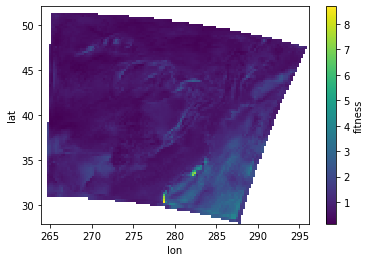

In [23]:
wrfdata['fitness'].plot()

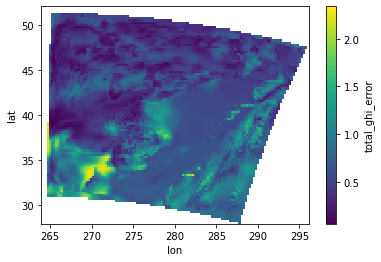

In [10]:
wrfdata.total_ghi_error.plot()

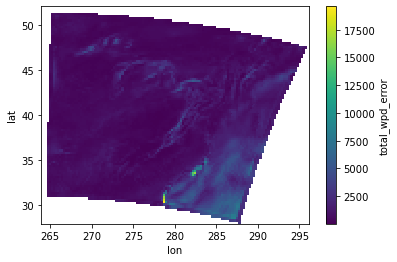

In [11]:
wrfdata.total_wpd_error.plot()

In [12]:
# I have to do this tedious string parsing below to get the projection from the processed wrfout file.
try:
    wrf_proj_params = wrfdata.dni.attrs['projection']
except AttributeError:
    raise ValueError('Variable does not contain projection information')
wrf_proj_params = wrf_proj_params.replace('(', ', ')
wrf_proj_params = wrf_proj_params.replace(')', '')
wrf_proj_params = wrf_proj_params.split(',')
wrf_proj = wrf_proj_params[0]
stand_lon = float(wrf_proj_params[1].split('=')[1])
moad_cen_lat = float(wrf_proj_params[2].split('=')[1])
truelat1 = float(wrf_proj_params[3].split('=')[1])
truelat2 = float(wrf_proj_params[4].split('=')[1])
pole_lat = float(wrf_proj_params[5].split('=')[1])
pole_lon = float(wrf_proj_params[6].split('=')[1])

# Fortunately, it still apppears to work.
if wrf_proj == 'LambertConformal':
    wrf_cartopy_proj = ccrs.LambertConformal(central_longitude=stand_lon,
                                             central_latitude=moad_cen_lat,
                                             standard_parallels=[truelat1, truelat2])
else: 
    print('Your WRF projection is not the expected Lambert Conformal.')
    raise ValueError

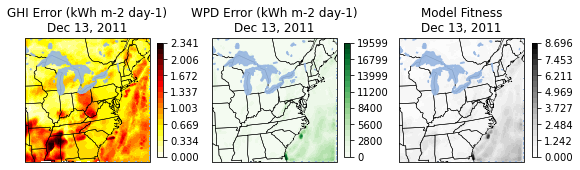

In [27]:
save_fig = True
# Create a figure
fig = plt.figure(figsize=(9.5,3))

# Set the GeoAxes to the projection used by WRF
ax_ghierr = fig.add_subplot(1,3,1, projection=wrf_cartopy_proj)
ax_wpderr = fig.add_subplot(1,3,2, projection=wrf_cartopy_proj, sharey=ax_ghierr)
ax_fitness= fig.add_subplot(1,3,3, projection=wrf_cartopy_proj, sharey=ax_wpderr)

# Format, and set the map bounds
# Get the projected bounds telling cartopy that the input coordinates are lat/lon (Plate Carree)
proj_bounds = wrf_cartopy_proj.transform_points(ccrs.PlateCarree(), 
                                                np.array([raw_bounds.bottom_left.lon, raw_bounds.top_right.lon]), 
                                                np.array([raw_bounds.bottom_left.lat, raw_bounds.top_right.lat]))
# Format the projected bounds so they can be used in the xlim and ylim attributes
proj_xbounds = [proj_bounds[0,0], proj_bounds[1,0]]
proj_ybounds = [proj_bounds[0,1], proj_bounds[1,1]]
# Finally, set the x and y limits
ax_ghierr.set_xlim(proj_xbounds)
ax_ghierr.set_ylim(proj_ybounds)
ax_wpderr.set_xlim(proj_xbounds)
ax_wpderr.set_ylim(proj_ybounds)
ax_fitness.set_xlim(proj_xbounds)
ax_fitness.set_ylim(proj_ybounds)

# Download and add the states, coastlines, and lakes
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

# Add features to the maps
ax_ghierr.add_feature(states, linewidth=.5, edgecolor="black")
ax_ghierr.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax_ghierr.add_feature(cfeature.OCEAN.with_scale('50m'))
ax_wpderr.add_feature(states, linewidth=.5, edgecolor="black")
ax_wpderr.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax_wpderr.add_feature(cfeature.OCEAN.with_scale('50m'))
ax_fitness.add_feature(states, linewidth=.5, edgecolor="black")
ax_fitness.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax_fitness.add_feature(cfeature.OCEAN.with_scale('50m'))

# Add the filled contour levels
ghierr_cn = ax_ghierr.contourf(to_np(wrfdata.lon), to_np(wrfdata.lat), to_np(wrfdata['total_ghi_error']), 
                               np.linspace(0, np.amax(wrfdata['total_ghi_error']), 22), 
                               transform=ccrs.PlateCarree(), cmap=get_cmap("hot_r"))
wpderr_cn = ax_wpderr.contourf(to_np(wrfdata.lon), to_np(wrfdata.lat), to_np(wrfdata['total_wpd_error']), 
                               np.linspace(0, np.amax(wrfdata['total_wpd_error']), 22), 
                               transform=ccrs.PlateCarree(), cmap=get_cmap("Greens"))
fitness_cn = ax_fitness.contourf(to_np(wrfdata.lon), to_np(wrfdata.lat), to_np(wrfdata['fitness']), 
                               np.linspace(0, np.amax(wrfdata['fitness']), 22), 
                               transform=ccrs.PlateCarree(), cmap=get_cmap("Greys"))

# Add color bars
plt.colorbar(ghierr_cn, ax=ax_ghierr, shrink=.7)
plt.colorbar(wpderr_cn, ax=ax_wpderr, shrink=.7)
plt.colorbar(fitness_cn, ax=ax_fitness, shrink=.7)

# Add the axis title
time_string_f = wrfdata.Time[0].dt.strftime('%b %d, %Y')
ax_ghierr.set_title(f'GHI Error (kWh m-2 day-1)\n{time_string_f.values}')
ax_wpderr.set_title(f'WPD Error (kWh m-2 day-1)\n{time_string_f.values}')
ax_fitness.set_title(f'Model Fitness\n{time_string_f.values}')

if save_fig:
    fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/daily_GHI_WPD_Err_Fitness_plot_{datestr}_{paramstr}'
    plt.savefig(fig_path + '.pdf', transparent=True, bbox_inches='tight')
                             
plt.show()

## OLD Plotting functions start here --------------------------------------------------------------------